## NAIVE BAYES

In [1]:
%matplotlib inline

# import libraries
import copy
import numpy as np
import scipy as sp
#import matplotlib as mpl
#import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# setup Seaborn
sns.set_style('whitegrid')
sns.set_context('poster')

In [2]:
# machine learning libraries 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
# import data
data_reviews = pd.read_csv('Data_rating_112_airlines_V2.csv')

In [4]:
# make a copy of the data
data_ratings = data_reviews.copy()

In [5]:
# adding second recommended column
data_ratings['recommended_2'] = data_ratings['recommended']

In [6]:
# replace values in recommended_2 column
data_ratings = data_ratings.replace({'recommended_2': {0: 'No', 1: 'Yes'}})

In [7]:
# drop rows with missing content
data_ratings = data_ratings[~data_ratings.content.isnull()]
data_ratings.head()

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,recommended_2
0,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,P Vlogianitis,Australia,2015-08-01,"Flight to Larnaca was a joy. Generous legroom,...",A321,Family Leisure,Business Class,Athens to Larnaca,10.0,5.0,5.0,5.0,NaN,3.0,NaN,5.0,1,Yes
1,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Eric Botha,United Kingdom,2015-07-28,"Flight on time, row 1 - Friendly staff and ver...",A321,Couple Leisure,Business Class,Athens to London,8.0,4.0,5.0,4.0,2.0,4.0,NaN,4.0,1,Yes
2,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Nathan Vermeulen,Belgium,2015-07-26,Very good flight with Aegean. The boarding was...,A320-232,Family Leisure,Economy,Brussels to Heraklion,9.0,4.0,5.0,4.0,NaN,4.0,NaN,4.0,1,Yes
3,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,N Sunder,United States,2015-07-21,"Brand new A320, interior spotless. Crew immacu...",A320,Solo Leisure,Economy,Mykonos to Athens,8.0,4.0,4.0,NaN,NaN,4.0,NaN,4.0,1,Yes
4,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Dimitrios Chrysos-Gklavas,Greece,2015-07-21,I booked a premium economy ticket so I can hav...,Dash 8 Q400,Solo Leisure,Economy,Athens to Santorini,8.0,4.0,5.0,4.0,NaN,2.0,NaN,3.0,1,Yes


### 1. DATA EXPLORATION

In [8]:
# get more information about columns in dataframe
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35609 entries, 0 to 35608
Data columns (total 21 columns):
airline_name                     35609 non-null object
link                             35609 non-null object
title                            35609 non-null object
author                           35609 non-null object
author_country                   35396 non-null object
date                             35609 non-null object
content                          35609 non-null object
aircraft                         1153 non-null object
type_traveller                   2164 non-null object
cabin_flown                      34138 non-null object
route                            2128 non-null object
overall_rating                   32275 non-null float64
seat_comfort_rating              31415 non-null float64
cabin_staff_rating               31417 non-null float64
food_beverages_rating            31020 non-null float64
inflight_entertainment_rating    28980 non-null float64
ground_se

In [9]:
# check number of reviews, number of authors and number of airlines
n_reviews = len(data_ratings)
n_airlines = data_ratings.airline_name.unique().size
n_authors = data_ratings.author.unique().size


print('Number of reviews: {:d}'.format(n_reviews))
print('Number of authors: {:d}'.format(n_authors))
print('Number of airlines:  {:d}'.format(n_airlines))

Number of reviews: 35609
Number of authors: 25938
Number of airlines:  112


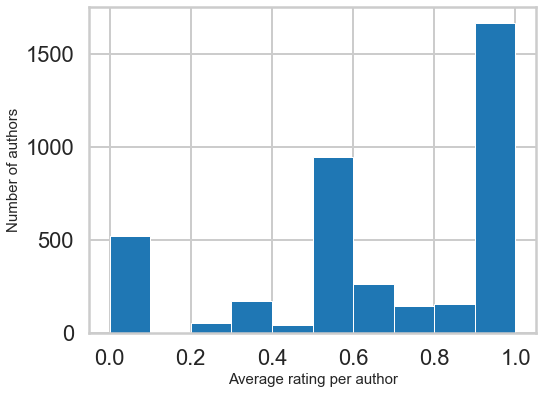

In [10]:
# create a copy of dataframe
df_copy = data_ratings.copy()

# change values in recommended_2 column to True if the value is Yes and False if it isn't
df_copy['recommended_2'] = df_copy.recommended_2 == 'Yes'

# group dataframe by author
grouped_author = df_copy.groupby('author')

# number of reviews by each author
grouped_author_counts = grouped_author.author.count()

# average recommended rating for each author
grouped_author_means = grouped_author.recommended_2.mean()     

# plot a histogram for authors with more than 1 review
grouped_author_means[grouped_author_counts > 1].hist(bins=10, edgecolor='w', lw=1, figsize=(8,6))
plt.xlabel('Average rating per author', fontsize=15)
plt.ylabel('Number of authors', fontsize=15)
plt.show()

By looking at the histogram, we can see that many authors on average recommended an airline they flew with. And on average around 500 authors didn't recommend an airline. Around 900 authors gave on average half the time recommended rate 1 and half the time rate 0. 

### 2. MULTINOMINAL NAIVE BAYES

In [12]:
# define X and y from dataframe
def make_xy(data_ratings, vectorizer=None):   
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data_ratings.content)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (data_ratings.recommended_2 == 'Yes').values.astype(np.int)
    return X, y
X, y = make_xy(data_ratings)

In [13]:
# split the dataframe into a training and test set
xtrain_1, xtest_1, ytrain_1, ytest_1 = train_test_split(X, y)

In [14]:
# use `scikit-learn`'s `MultinomialNB()` classifier with default parameters
clf = MultinomialNB()

# train the classifier over the training set
clf.fit(xtrain_1, ytrain_1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
# test on the test set
predict_1 = clf.predict(xtest_1)

In [17]:
# print the accuracy scores for both the training and the test sets
print('Accuracy on training set: ', clf.score(xtrain_1, ytrain_1))
print('Accuracy on test set: ', clf.score(xtest_1, ytest_1))

Accuracy on training set:  0.8600314536059313
Accuracy on test set:  0.8423003481972369


#### 1.1 Picking hyperparameters for Naive Bayes and text maintenance

In [18]:
# create a list of word count
doc_freq = sorted((X > 0).sum(axis=0).tolist()[0])

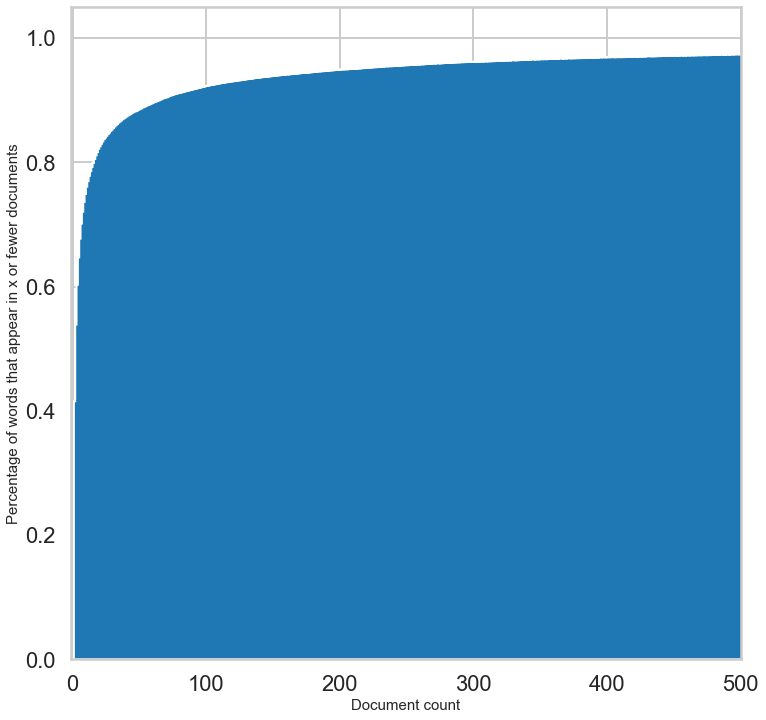

In [19]:
# plot the cumulative distribution of document frequencies
plt.figure(figsize=(12,12))
_ = plt.hist(pd.Series(doc_freq), np.arange(pd.Series(doc_freq).sum()), cumulative=True, histtype='stepfilled', density=True)
_ = plt.xlabel('Document count', fontsize=15)
_ = plt.ylabel('Percentage of words that appear in x or fewer documents', fontsize=15)
_ = plt.xlim(-1, 500)
plt.show()

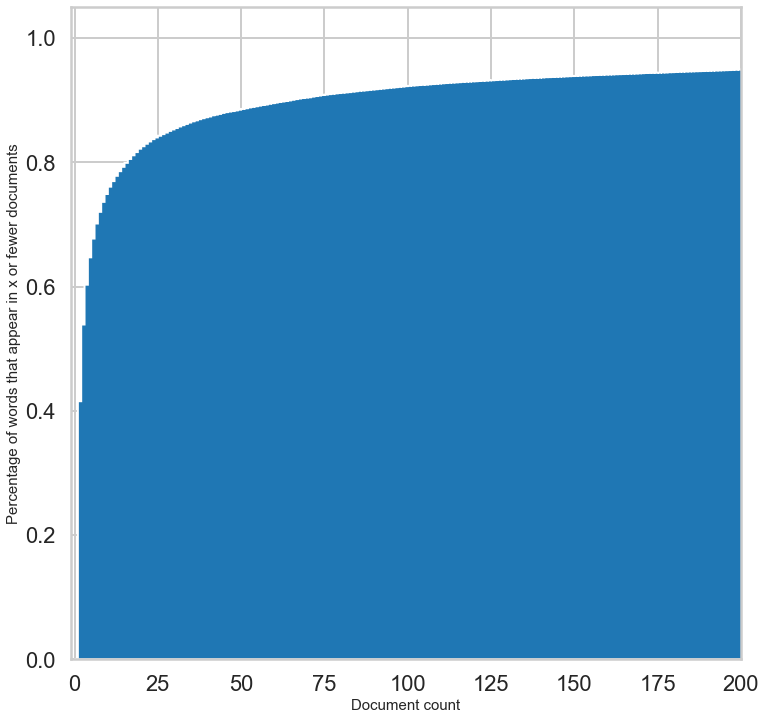

In [35]:
# plot the  cumulative distribution of document frequencies on a smaller scale
plt.figure(figsize=(12,12))
_ = plt.hist(pd.Series(doc_freq), np.arange(pd.Series(doc_freq).sum()), cumulative=True, histtype='stepfilled', density=True)
_ = plt.xlabel('Document count', fontsize=15)
_ = plt.ylabel('Percentage of words that appear in x or fewer documents', fontsize=15)
_ = plt.xlim(-1, 200)
plt.show()

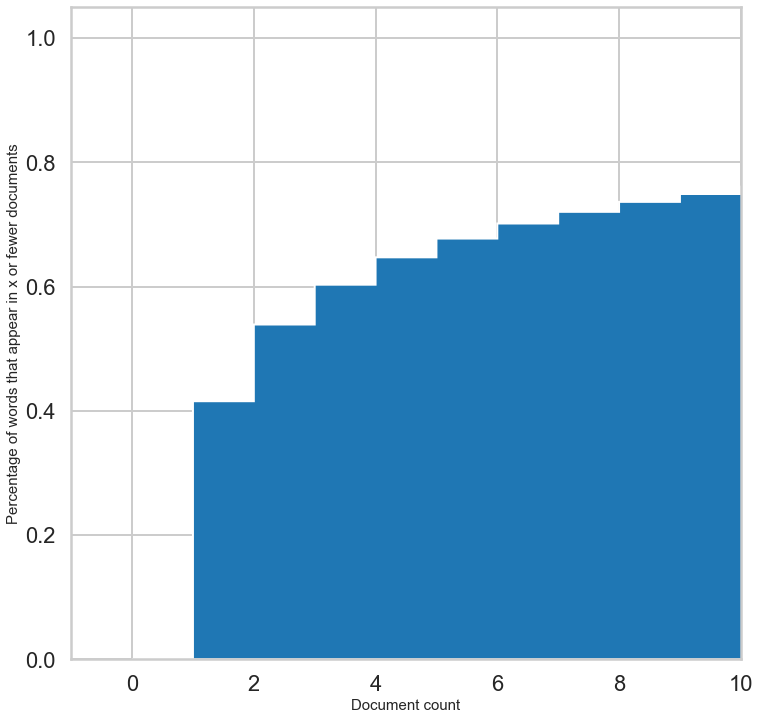

In [36]:
# plot the  cumulative distribution of document frequencies on a smaller scale
plt.figure(figsize=(12,12))
_ = plt.hist(pd.Series(doc_freq), np.arange(pd.Series(doc_freq).sum()), cumulative=True, histtype='stepfilled', density=True)
_ = plt.xlabel('Document count', fontsize=15)
_ = plt.ylabel('Percentage of words that appear in x or fewer documents', fontsize=15)
_ = plt.xlim(-1, 10)
plt.show()

If we look at the above graphs, we can see that at x=2 the curve begins climbing steeply, this could be our value for best 'min_df'. 

In [24]:
# create a score function
# the function cv_score performs the K-fold cross-validation algorithm
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed in as clf
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold #  return the average

In [25]:
# define the log-likelihood function
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    No = y == 0
    Yes = ~No
    return prob[No, 0].sum() + prob[Yes, 1].sum()

In [26]:
# set up the train and test masks
_, itest = train_test_split(range(data_ratings.shape[0]), train_size=0.7)
mask = np.zeros(data_ratings.shape[0], dtype=np.bool)
mask[itest] = True

In [27]:
# the grid of parameters to search over
alphas_2 = [.1, 1, 5, 10, 50]
best_min_df_2 = 2 # value we chose from plotted histogram above

# find the best value for alpha and min_df, and the best classifier
best_alpha_2 = None
maxscore_2 = -np.inf
for alpha in alphas_2:        
    vectorizer_2 = CountVectorizer(min_df=best_min_df_2)       
    Xthis_2, ythis_2 = make_xy(data_ratings, vectorizer_2)
    Xtrainthis_2 = Xthis_2[mask]
    ytrainthis_2 = ythis_2[mask]
    clf_2 = MultinomialNB(alpha=alpha)
    score_2 = cv_score(clf_2, Xtrainthis_2, ytrainthis_2, log_likelihood)
    print('alpha:', alpha, 'score:', score_2)
    if score_2 > maxscore_2:
        maxscore_2 = score_2
        best_alpha_2 = alpha
print('With min_df = 1, the best alpha is:', best_alpha_2 ,'and has max score:', maxscore_2)

alpha: 0.1 score: -4034.0845220611604
alpha: 1 score: -3680.3588753597737
alpha: 5 score: -3406.3464512192927
alpha: 10 score: -3273.990701777825
alpha: 50 score: -3275.252131630498
With min_df = 1, the best alpha is: 10 and has max score: -3273.990701777825


In [28]:
# the grid of parameters to search over
alphas = [0, 0.1, 1, 5, 10, 50]
min_dfs = [0.001, 0.01, 0.1, 1, 2, 3, 5, 10, 15, 20, 50, 80] 

# find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None 
maxscore = -np.inf

for alpha in alphas: 
    for min_df in min_dfs: 
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(data_ratings, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf_IV = MultinomialNB(alpha = alpha)
        cvscore = cv_score(clf_IV, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha = alpha 
            best_min_df = min_df

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e'

In [29]:
# print calculated best values
print('alpha: {}'.format(best_alpha))
print('best min_df: {}'.format(best_min_df))
print('best score: {}'.format(maxscore))

alpha: 50
best min_df: 0.1
best score: -1860.8521335315781


### 2. WORKING WITH THE BEST PARAMETERS

In [30]:
# make a model from the best parameters
vectorizer_3 = CountVectorizer(min_df=best_min_df)
X, y = make_xy(data_ratings, vectorizer_3)
xtrain_2 = X[mask]
ytrain_2 = y[mask]
xtest_2 = X[~mask]
ytest_2 = y[~mask]

clf_3 = MultinomialNB(alpha=best_alpha).fit(xtrain_2, ytrain_2)

# print the accuracy on the test and training dataset
training_accuracy_3 = clf_3.score(xtrain_2, ytrain_2)
test_accuracy_3 = clf_3.score(xtest_2, ytest_2)

print('Accuracy on training data: {:2f}'.format(training_accuracy_3))
print('Accuracy on test data:     {:2f}'.format(test_accuracy_3))

Accuracy on training data: 0.792380
Accuracy on test data:     0.788975


#### 2.1. The confusion matrix

In [34]:
# print confusion matrix 
print(confusion_matrix(ytest_2, clf_3.predict(xtest_2)))

[[ 8362  3011]
 [ 2249 11304]]


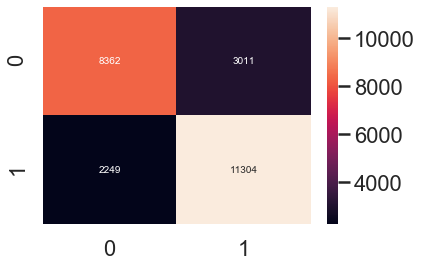

In [35]:
# plot the confusion matrix
sns.heatmap(confusion_matrix(ytest_2, clf_3.predict(xtest_2)), annot=True, fmt='d')

True Positive = 11304 (Observation is positive, and is predicted to be positive. Number of instances of positive class '1' correctly predicted.)

True Negative = 8362 (Observation is negative, and is predicted to be negative. Number of instances of negative class '0' correctly predicted.)

False Positive = 3011 (Observation is negative, but is predicted positive. Number of instances of negative class '0' incorrectly predicted as the positive class '1'.)

False Negative = 2249 (Observation is positive, but is predicted negative. Number of instances of positive class '1' incorrectly predicted as the negative class '0'.)

#### 2.2. Evaluating the precision and recall metric for our training data

In [36]:
# instantiate the classifier
nb_classifier = MultinomialNB(alpha=best_alpha)

# fit to the training data
nb_classifier.fit(xtrain_2, ytrain_2)

# predict the labels
pred_labels = nb_classifier.predict(xtest_2)

In [37]:
# create a machine learning pipelines
pipe_NB = make_pipeline(MultinomialNB())

In [38]:
# compute predicted y's
predicted_NB = cross_val_predict(pipe_NB, X, y, cv=3, n_jobs=-1)

Let's check the Text summary of the precision, recall, F1 score for each recommended rating class (0, 1). 

A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True Negatives and False Negatives are used to predict the metrics of a classification report as shown below. 

In [39]:
# classification report
print('Multinomial Naive Bayes:') 
print(classification_report(y, predicted_NB)) 
print('\n')

Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76     16231
           1       0.79      0.84      0.81     19378

    accuracy                           0.79     35609
   macro avg       0.79      0.79      0.79     35609
weighted avg       0.79      0.79      0.79     35609





First, let's refresh the meaning of each parameter in the report:
The precision is the ratio between the number of true positives and the number of false positives. Precision is the ability of a classifier not to label an instance positive that is actually negative.

The recall is the ratio between the number of true positives and the number of false negatives. Recall is the ability of a classifier to find all positive instances.

The F-beta score can be interpreted as a weighted harmonic mean of precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true (correct target values).

The reported averages include macro average, which represents averaging the unweighted mean per label. And weighted average, which is averaging the support-weighted mean per label.

The precision and recall rates give us an idea about the discriminative ability of our classifier. In this case our average precision and recall rates are both 0.79. But if we look for each class, we can see that recall is higher for class 1 (travellers recommended airline).
For the accuracy we get the similar result as we did above for the accuracy on the training set (in cell 30).



#### 2.3. What are the strongly predictive features?

In [40]:
# find good and bad words from the model with best parameters
words_1 = np.array(vectorizer_3.get_feature_names())

h = np.eye(xtest_2.shape[1])
probs = clf_3.predict_log_proba(h)[:, 0]
ind = np.argsort(probs)

good_words = words_1[ind[:10]]
bad_words = words_1[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print('Good words\t     P(Yes | word)')
for w, p in zip(good_words, good_prob):
    print('{:>20}'.format(w), '{:.2f}'.format(1 - np.exp(p)))
    
print('Bad words\t     P(Yes | word)')
for w, p in zip(bad_words, bad_prob):
    print('{:>20}'.format(w), '{:.2f}'.format(1 - np.exp(p)))

Good words	     P(Yes | word)
           excellent 0.91
         comfortable 0.86
               great 0.85
            friendly 0.84
                nice 0.84
                good 0.83
                well 0.75
                both 0.75
              drinks 0.71
                very 0.71
Bad words	     P(Yes | word)
                  no 0.40
                  we 0.39
                then 0.39
             because 0.38
                next 0.38
                 our 0.36
             delayed 0.35
               hours 0.33
               never 0.27
                told 0.17


By looking at both categories of words, we can say that our classifier did correctly identified them. Words like 'excellent', 'great', 'nice', are definitely good/positive words. On the other hand, 'no', 'delayed' and 'never' are words that are not associated with something good.

#### 2.4. Prediction errors

We can see mis-predictions as well:

In [41]:
x, y = make_xy(data_ratings, vectorizer_3)

prob = clf_3.predict_proba(x)[:, 0]
predict = clf_3.predict(x)

bad_no = np.argsort(prob[y == 0])[:5]
bad_yes = np.argsort(prob[y == 1])[-5:]

print('Mis-predicted Not recommended quotes')
print('---------------------------')
for row in bad_no:
    print(data_ratings[y == 0].content.iloc[row])
    print("")

print('Mis-predicted Yes recommended quotes')
print('--------------------------')
for row in bad_yes:
    print(data_ratings[y == 1].content.iloc[row])
    print('')

Mis-predicted Not recommended quotes
---------------------------
LIS-LHR-VIE on Dec. 8 both legs on an Airbus 320 in Club Europe (Business Class) - both legs on time seats were Economy seats with the middle seat left unsold and featuring the new slim seats which are less comfortable and have a reduced seat pitch – Check-in in LIS was handled by rather surly agents which was untypical for an otherwise friendly airport but Business class waiting lines were very short so overall it was OK. LIS-LHR leg was with a rather lacklustre and inattentive European fleet crew after the initial service of food and drinks further service consisted of clearing the dishes and on board sales. Other than that Business class flight attendants were behind the curtain reading magazines chatting and rather attending to themselves than the passengers. At 11 am the Business Class food served was a plate cold cuts a roll and three thin slices of fruit (basically a make yourself sandwich on a plate). Extremely di

### 3. TERM-FREQUENCY x INVERSE DOCUMENT FREQUENCY

We can use Tfidfvectorizer to compute tf-idf scores on documents within our training dataset.

With Tfidfvectorizer we compute the word counts, idf and tf-idf values all at once:

In [54]:
# initiate TfidfVectorizer to get the tf-idf scores of a set of documents
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf = tfidf_vectorizer.fit_transform(data_ratings.content)

In [57]:
# check the shape 
print(Xtfidf.shape)

(35609, 33348)


In [58]:
# array mapping from feature integer indices to feature name
print(tfidf_vectorizer.get_feature_names())

['00', '000', '0001', '0003', '0004', '0005', '0007', '0009', '001', '0017', '0018', '002', '0027', '003', '0030', '0031', '0035', '004', '0040', '005', '0050', '0055', '0058', '006', '0066', '0067', '0069', '007', '008', '0082', '0086', '0089', '009', '0090', '00am', '00flight', '00hrs', '00pm', '01', '010', '0100', '0102', '0103', '0105', '011', '0110', '0117', '0118', '012', '0120', '0130', '0130hrs', '0135', '0138', '0140am', '0141', '0145', '015', '0150', '0150hrs', '0153', '0155', '016', '0176', '018', '019', '01d', '01e', '01f', '01h10', '02', '020', '0200', '0200hrs', '021', '0215', '0216', '022', '023', '0230', '0230am', '0235', '024', '0245', '025', '0254', '026', '0264', '0267', '027', '028', '029', '02c', '02pm', '03', '030', '0300', '0301', '0303', '0304', '031', '0315', '0325', '0333', '034', '0341', '0348', '035', '0352', '036', '038', '0383', '0384', '039', '0392', '03a', '03c', '03j', '03kg', '03pm', '04', '0400', '0410', '0415', '0416', '0430', '0434', '0439', '0441hr

Now let’s print the tfidf values for the first document from our collection:

In [71]:
# print the first document from our dataset
data_ratings.content.iloc[0]

'Flight to Larnaca was a joy. Generous legroom, nice meals and a fantastic range of drinks to choose from. Crew was attentive and it is nice that Aegean leave the cockpit door open during boarding..'

In [59]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = Xtfidf[0]
 
# place tf-idf values in a pandas dataframe
df_Xtfidf = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=['tfidf'])
df_Xtfidf.sort_values(by=['tfidf'], ascending=False)

,tfidf
larnaca,0.334086
joy,0.329226
aegean,0.308871
cockpit,0.293046
nice,0.292326
range,0.260963
generous,0.254805
door,0.244539
open,0.226837
fantastic,0.217214


What we can notice that only certain words have scores. This is because our first document, printed above, has all the words that have a tf-idf score and everything else show up as zeroes. Words like 'a' or 'and' are missing from this list, because stop words are removed during processing.

The scores above make sense. The more common the word across documents, the lower its score and the more unique a word is to our first document (e.g. ‘larnaca’ and ‘aegean’) the higher the score.